# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  


In [4]:
# What model to use
#MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_NAME = 'faster_rcnn_nas_lowproposals_coco_2017_11_08'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Function to Load a (frozen) Tensorflow model into memory and function to convert image into numpy array

In [5]:
def load_detection_model(PATH_TO_CKPT=PATH_TO_CKPT):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Function to Process image

In [6]:
def detection_operations():
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    return image_tensor, detection_boxes, detection_scores, detection_classes, num_detections

In [7]:
def process_image(image):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(image, np.squeeze(boxes), np.squeeze(classes).astype(np.int32),np.squeeze(scores),category_index,use_normalized_coordinates=True,line_thickness=8)
            return image            

In [8]:
def clear_cache():
    process_image.cache = None

## Loading label map and load model

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [10]:
detection_graph = load_detection_model()
image_tensor, detection_boxes, detection_scores, detection_classes, num_detections = detection_operations()

# Detection

In [11]:
write_output = 'output_video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first n seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4")
#clear_cache()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|██████████████████████████████████▉| 1260/1261 [10:59:13<00:31, 31.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

Wall time: 10h 59min 15s


In [12]:

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_car_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
print(TEST_IMAGE_PATHS)

['test_car_images\\image1.jpg', 'test_car_images\\image2.jpg', 'test_car_images\\image3.jpg']


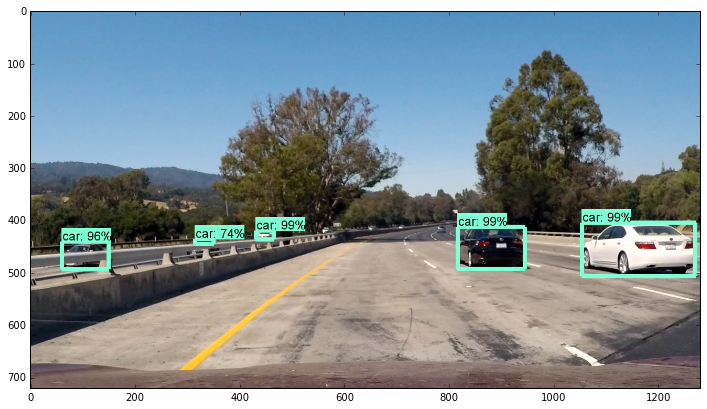

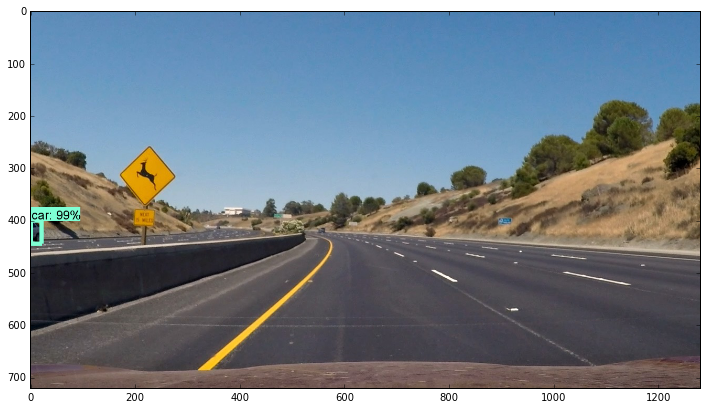

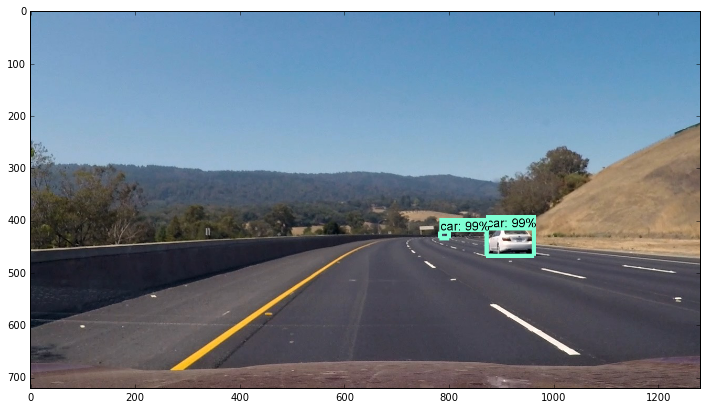

In [13]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    image_processed=process_image(image_np)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_processed)